In [0]:
or_dat = spark.table("orders_dataset")
or_item = spark.table("order_items_dataset")
cust = spark.table("customers_dataset")
or_pay = spark.table("order_payments_dataset")
or_review = spark.table("order_reviews_dataset")
products = spark.table("products_dataset")
pro_category = spark.table("product_category_name_translation")
geo = spark.table("geolocation_dataset")
sell = spark.table("sellers_dataset")

In [0]:
from pyspark.sql import functions as F

spark.sql("USE CATALOG customersegmentation")
spark.sql("USE default")
order_cust = (
    or_dat
    .join(cust, on="customer_id", how="left")
)

order_cust.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|            order_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+------------------------+--------------------+--------------+
|8ab97904e6daea886...|ad21c59c0840e6cb8...|   delivered|     2018-02-13 21:18:39|2018-02-13 22:20:29|         2018-02-14 19:46:34|          2018-02-16 18:17:02|          2018-02-26 

In [0]:
df = order_cust.join(or_item, on="order_id", how="left")
df.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+------------------------+--------------------+--------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+------------------------+--------------------+-----

In [0]:
df = df.drop(
    "customer_id",
    "seller_id",
    "shipping_limit_date",
    "customer_zip_code_prefix"
)


In [0]:
df = df.filter(df.order_status == "delivered")


In [0]:
df = df.drop("order_status")


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType

date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df = df.withColumn(col, F.to_timestamp(F.col(col)))


In [0]:
from pyspark.sql.types import StringType

df = df.withColumn("order_item_id", F.col("order_item_id").cast(StringType()))

In [0]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# Define a window partitioned by all columns
w = Window.partitionBy(df.columns)

# Count how many times each row appears
df_with_dup_count = df.withColumn("dup_count", F.count("*").over(w))

# Count only rows that are duplicates (appear more than once)
duplicate_count = df_with_dup_count.filter(F.col("dup_count") > 1) \
                                   .select(F.sum(F.col("dup_count") - 1)) \
                                   .collect()[0][0]

print(duplicate_count)


None


In [0]:

missing_df = df.select([
    (F.count(F.when(F.col(c).isNull(), 1)) / df.count()).alias(c) 
    for c in df.columns
])

missing_df.show()


+--------+------------------------+--------------------+----------------------------+-----------------------------+-----------------------------+------------------+-------------+--------------+-------------+----------+-----+-------------+
|order_id|order_purchase_timestamp|   order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|customer_unique_id|customer_city|customer_state|order_item_id|product_id|price|freight_value|
+--------+------------------------+--------------------+----------------------------+-----------------------------+-----------------------------+------------------+-------------+--------------+-------------+----------+-----+-------------+
|     0.0|                     0.0|1.361198580723613...|        1.814931440964817...|         7.259725763859271E-5|                          0.0|               0.0|          0.0|           0.0|          0.0|       0.0|  0.0|          0.0|
+--------+------------------------+---------

In [0]:
from pyspark.sql import functions as F

# compute missing percentage per column in long format
missing_df = df.select([
    (F.count(F.when(F.col(c).isNull(), 1)) / df.count()).alias(c)
    for c in df.columns
]).selectExpr(
    "stack({}, {}) as (column, persentase_missing)".format(
        len(df.columns),
        ', '.join([f"'{c}', {c}" for c in df.columns])
    )
)

missing_df.show()


+--------------------+--------------------+
|              column|  persentase_missing|
+--------------------+--------------------+
|            order_id|                 0.0|
|order_purchase_ti...|                 0.0|
|   order_approved_at|1.361198580723613...|
|order_delivered_c...|1.814931440964817...|
|order_delivered_c...|7.259725763859271E-5|
|order_estimated_d...|                 0.0|
|  customer_unique_id|                 0.0|
|       customer_city|                 0.0|
|      customer_state|                 0.0|
|       order_item_id|                 0.0|
|          product_id|                 0.0|
|               price|                 0.0|
|       freight_value|                 0.0|
+--------------------+--------------------+



In [0]:
df = df.dropna(how="any", subset=["order_purchase_timestamp", "order_item_id"])


In [0]:
from pyspark.sql import functions as F

# Count nulls per column in wide format
null_counts_wide = df.select([
    F.count(F.when(F.col(c).isNull(), 1)).alias(c) 
    for c in df.columns
])

# Convert to long format
null_counts_long = null_counts_wide.selectExpr(
    "stack({}, {}) as (column, null_count)".format(
        len(df.columns),
        ', '.join([f"'{c}', {c}" for c in df.columns])
    )
)

null_counts_long.show()


+--------------------+----------+
|              column|null_count|
+--------------------+----------+
|            order_id|         0|
|order_purchase_ti...|         0|
|   order_approved_at|        15|
|order_delivered_c...|         2|
|order_delivered_c...|         8|
|order_estimated_d...|         0|
|  customer_unique_id|         0|
|       customer_city|         0|
|      customer_state|         0|
|       order_item_id|         0|
|          product_id|         0|
|               price|         0|
|       freight_value|         0|
+--------------------+----------+



In [0]:
num_rows = df.count()       # counts the number of rows
num_cols = len(df.columns)  # counts the number of columns

print((num_rows, num_cols))


(110197, 13)


In [0]:
from pyspark.sql import functions as F

df = (
    df
    .withColumn("purchase_year", F.year("order_purchase_timestamp"))
    .withColumn("purchase_month", F.date_format("order_purchase_timestamp", "MMM"))
    .withColumn("purchase_yearmonth", F.date_format("order_purchase_timestamp", "yyyyMM"))
    .withColumn("purchase_dayofweek", F.date_format("order_purchase_timestamp", "E"))
    .withColumn(
        "purchase_period", 
        F.create_map(
            F.lit(1), F.lit("Late Night"),
            F.lit(2), F.lit("Early Morning"),
            F.lit(3), F.lit("Morning"),
            F.lit(4), F.lit("Noon"),
            F.lit(5), F.lit("Evening"),
            F.lit(6), F.lit("Night")
        )[ ((F.hour("order_purchase_timestamp") + 4) / 4).cast("integer") ]
    )
    .withColumn("month_num", F.month("order_purchase_timestamp"))
)

df.limit(5).toPandas()


,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,order_item_id,product_id,price,freight_value,purchase_year,purchase_month,purchase_yearmonth,purchase_dayofweek,purchase_period,month_num
0,ce9feeba53c652dd6569cca62e2bb287,2018-04-15 19:42:06,2018-04-15 19:55:20,2018-04-19 14:32:30,2018-04-20 23:12:11,2018-04-26,d01cf8c6c7c836c5dd9320585928f42b,barueri,SP,1,28b5fef7b6d63771e9784bc68c783793,45.0,11.86,2018,Apr,201804,Sun,Evening,4
1,c7911a821f0816b0c1345016668c7752,2018-06-08 16:47:20,2018-06-08 20:31:45,2018-06-11 14:20:00,2018-07-02 16:52:34,2018-07-03,01a4788c8bd6d0d6a5b16ccdfd393b74,rio das ostras,RJ,1,3cc6750606d3429d08a50f6416b82dd2,64.0,19.42,2018,Jun,201806,Fri,Evening,6
2,c63664068aa3636080c2cd77c53971ab,2017-12-04 17:01:15,2017-12-04 17:46:53,2017-12-05 21:48:35,2017-12-22 20:09:32,2017-12-28,bf6d9bf8866ac722b1033fe81229a233,ituiutaba,MG,1,381c84a4eb64a931d793f69112d5a34c,49.9,20.84,2017,Dec,201712,Mon,Evening,12
3,b526245df7becef98d5b08c6350cc53e,2018-01-15 18:00:35,2018-01-15 18:11:23,2018-01-17 13:09:20,2018-01-24 21:48:45,2018-02-05,fe50acde4870aa583fd28401916b7348,cosmopolis,SP,1,485977d79fe47209050d22d220aaab7f,139.9,47.69,2018,Jan,201801,Mon,Evening,1
4,6a4d031d68d8f41c14ee7cd194023800,2017-05-15 08:58:47,2017-05-15 09:10:17,2017-05-15 11:08:02,2017-05-22 22:44:44,2017-06-06,c3cc9ab026e263448a7e804dfada75f5,niteroi,RJ,1,5eccc2d95245db3260989916f2646afe,69.9,16.93,2017,May,201705,Mon,Morning,5


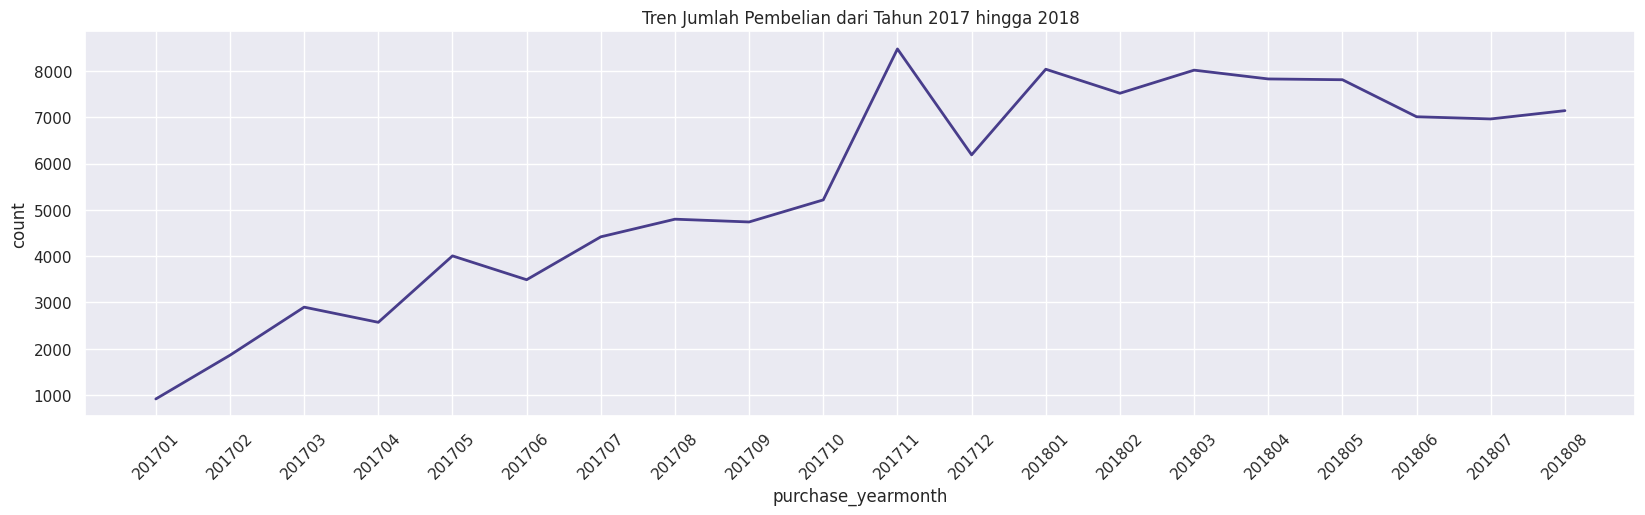

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1. Aggregate number of orders per year-month
orders_per_month = (
    df.groupBy("purchase_yearmonth")
      .count()
      .orderBy("purchase_yearmonth")
      .toPandas()   # collect small aggregated data to driver
)

# 2. Optional: filter out first 3 months if needed (like your [3:] slice)
orders_per_month = orders_per_month.iloc[3:]

# 3. Plot
sns.set(rc={'figure.figsize':(20,5)})
sns.lineplot(
    data=orders_per_month,
    x="purchase_yearmonth",
    y="count",
    color='darkslateblue',
    linewidth=2
)
plt.title('Tren Jumlah Pembelian dari Tahun 2017 hingga 2018')
plt.xticks(rotation=45)  # rotate x-axis for readability
plt.show()


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from functools import reduce

cols = ['purchase_year', 'purchase_yearmonth']

df = reduce(lambda d, c: d.withColumn(c, F.col(c).cast(IntegerType())), cols, df)


/home/spark-c62dcf22-5347-44a3-8b04-1d/.ipykernel/2566/command-5214476281148447-1424866908:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


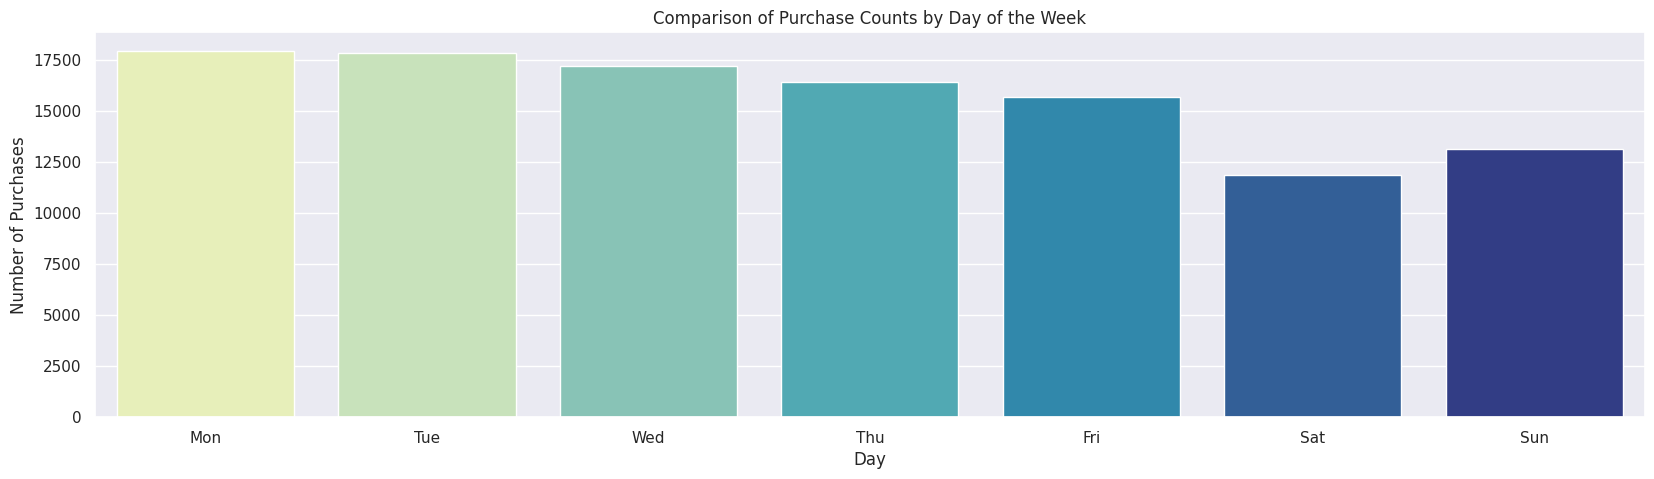

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
import pandas as pd

# 1. Aggregate counts per day-of-week
day_counts = (
    df.groupBy("purchase_dayofweek")
      .count()
      .toPandas()
)

# 2. Optional: order the days
order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
day_counts['purchase_dayofweek'] = pd.Categorical(day_counts['purchase_dayofweek'], categories=order, ordered=True)
day_counts = day_counts.sort_values('purchase_dayofweek')

# 3. Plot
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(
    data=day_counts, 
    x='purchase_dayofweek', 
    y='count', 
    palette='YlGnBu'
)
plt.title('Comparison of Purchase Counts by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Purchases')
plt.show()


In [0]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# Reference order for days
day_order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# Create a small Spark DataFrame for ordering
spark = df.sparkSession
order_df = spark.createDataFrame([(d, i) for i, d in enumerate(day_order)], ["purchase_dayofweek", "order"])

# Count per day
day_counts = (
    df.groupBy("purchase_dayofweek").count()
      .join(order_df, on="purchase_dayofweek")  # join with order reference
      .orderBy("order")                         # sort by reference order
      .drop("order")                            # drop the helper column
)

day_counts.show()


+------------------+-----+
|purchase_dayofweek|count|
+------------------+-----+
|               Mon|17973|
|               Tue|17858|
|               Wed|17219|
|               Thu|16434|
|               Fri|15698|
|               Sat|11885|
|               Sun|13130|
+------------------+-----+



/home/spark-c62dcf22-5347-44a3-8b04-1d/.ipykernel/2566/command-5214476281148449-1983325675:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


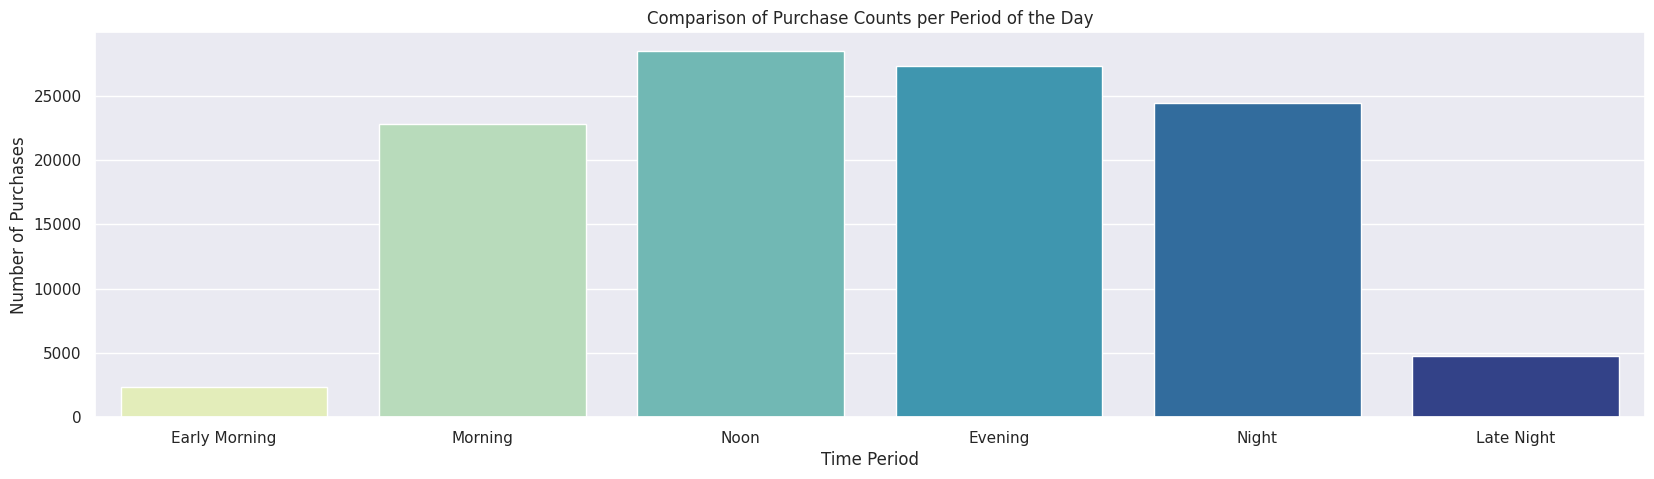

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
import pandas as pd

# 1. Aggregate counts per purchase_period
period_counts = (
    df.groupBy("purchase_period")
      .count()
      .toPandas()
)

# 2. Optional: order the periods
order = ['Early Morning', 'Morning', 'Noon', 'Evening', 'Night', 'Late Night']
period_counts['purchase_period'] = pd.Categorical(period_counts['purchase_period'], categories=order, ordered=True)
period_counts = period_counts.sort_values('purchase_period')

# 3. Plot
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(
    data=period_counts,
    x='purchase_period',
    y='count',
    palette='YlGnBu'
)
plt.title('Comparison of Purchase Counts per Period of the Day')
plt.xlabel('Time Period')
plt.ylabel('Number of Purchases')
plt.show()


In [0]:
from pyspark.sql import functions as F

order = ['Early Morning', 'Morning', 'Noon', 'Evening', 'Night', 'Late Night']

period_counts = df.select([
    F.sum(F.when(F.col("purchase_period") == p, 1).otherwise(0)).alias(p) 
    for p in order
])

period_counts.show()


+-------------+-------+-----+-------+-----+----------+
|Early Morning|Morning| Noon|Evening|Night|Late Night|
+-------------+-------+-----+-------+-----+----------+
|         2331|  22836|28514|  27285|24438|      4793|
+-------------+-------+-----+-------+-----+----------+



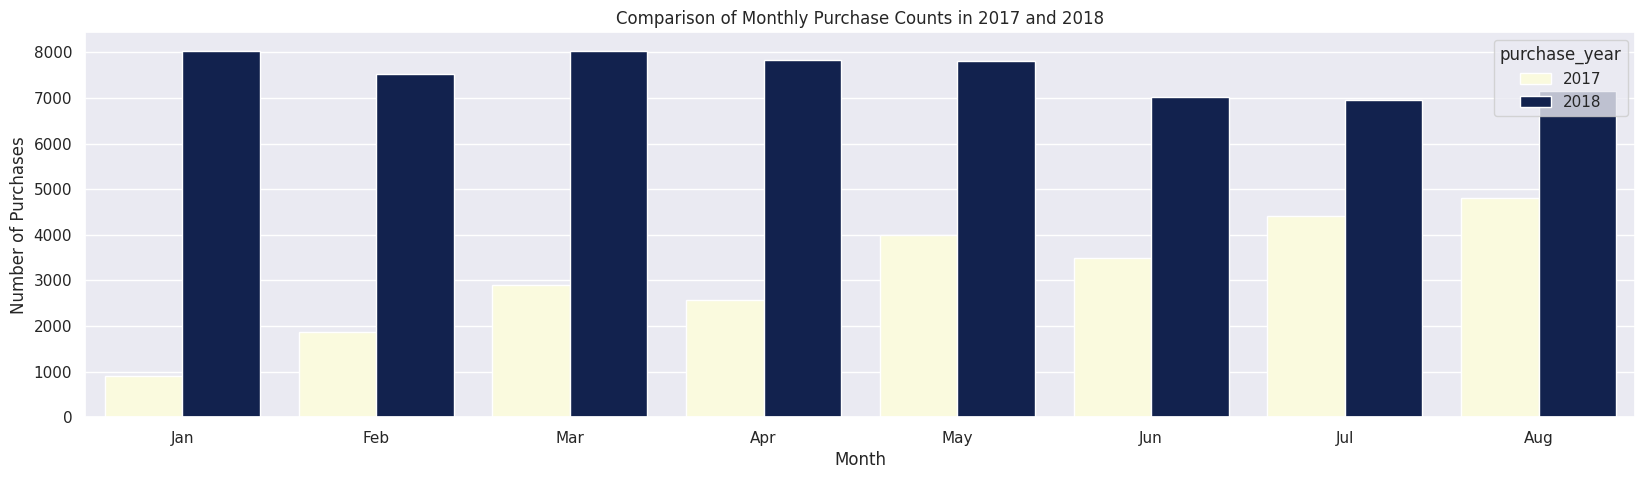

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
import pandas as pd

# 1. Filter for year 2017 or 2018 and months <= 8
df_compare = df.filter(
    (F.col("purchase_year").isin(2017, 2018)) &
    (F.col("month_num") <= 8)
)

# 2. Aggregate counts per month and year
month_year_counts = (
    df_compare.groupBy("purchase_year", "purchase_month")
               .count()
               .toPandas()
)

# 3. Optional: order months
order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
month_year_counts['purchase_month'] = pd.Categorical(month_year_counts['purchase_month'], categories=order, ordered=True)
month_year_counts = month_year_counts.sort_values('purchase_month')

# 4. Plot
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(
    data=month_year_counts,
    x='purchase_month',
    y='count',
    hue='purchase_year',
    palette='YlGnBu'
)
plt.title('Comparison of Monthly Purchase Counts in 2017 and 2018')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.show()


In [0]:
from pyspark.sql import functions as F

# 1. Filter for year 2017
df_2017 = df_compare.filter(F.col("purchase_year") == 2017)

# 2. Count per month
month_counts_2017 = df_2017.groupBy("purchase_month").count()

# 3. Optional: sort by month name (Jan → Aug)
order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
order_df = df_2017.sparkSession.createDataFrame([(m, i) for i, m in enumerate(order)], ["purchase_month", "order"])

month_counts_2017_ordered = month_counts_2017.join(order_df, on="purchase_month") \
                                             .orderBy("order") \
                                             .drop("order")

# 4. Convert to pandas (optional) to mimic pandas .value_counts() output
month_counts_2017_pd = month_counts_2017_ordered.toPandas().set_index("purchase_month")["count"]
print(month_counts_2017_pd)


purchase_month
Jan     913
Feb    1858
Mar    2897
Apr    2569
May    4004
Jun    3489
Jul    4416
Aug    4797
Name: count, dtype: int64


In [0]:
from pyspark.sql import functions as F

# 1. Filter for year 2018
df_2018 = df_compare.filter(F.col("purchase_year") == 2018)

# 2. Count per month
month_counts_2018 = df_2018.groupBy("purchase_month").count()

# 3. Preserve month order (Jan → Aug)
order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
order_df = df_2018.sparkSession.createDataFrame([(m, i) for i, m in enumerate(order)], ["purchase_month", "order"])

month_counts_2018_ordered = month_counts_2018.join(order_df, on="purchase_month") \
                                             .orderBy("order") \
                                             .drop("order")

# 4. Convert to pandas Series for pandas-like display
month_counts_2018_pd = month_counts_2018_ordered.toPandas().set_index("purchase_month")["count"]
print(month_counts_2018_pd)


purchase_month
Jan    8037
Feb    7518
Mar    8017
Apr    7827
May    7810
Jun    7010
Jul    6963
Aug    7142
Name: count, dtype: int64


In [0]:
from pyspark.sql import functions as F

# 1. Count orders per city
df_city = (
    df.groupBy("customer_city")
      .agg(F.count("order_id").alias("order_count"))
      .orderBy(F.desc("order_count"))
)

# 2. Convert top 10 cities to pandas (like head)
df_city_big = df_city.limit(10).toPandas()
print("Top 10 cities by number of purchases:")
print(df_city_big)

# 3. Convert bottom 20 cities to pandas (like tail)
# In Spark, tail() doesn’t exist; instead, we order ascending and take first 20
df_city_small = (
    df_city.orderBy("order_count")  # ascending
           .limit(20)
           .toPandas()
)
print("\nBottom 20 cities by number of purchases:")
print(df_city_small)


Top 10 cities by number of purchases:
           customer_city  order_count
0              sao paulo        17400
1         rio de janeiro         7592
2         belo horizonte         3087
3               brasilia         2341
4               curitiba         1727
5               campinas         1626
6           porto alegre         1573
7               salvador         1358
8              guarulhos         1294
9  sao bernardo do campo         1041

Bottom 20 cities by number of purchases:
           customer_city  order_count
0              umburanas            1
1           pedranopolis            1
2              ibiracatu            1
3             felisburgo            1
4                  pavao            1
5                candeal            1
6        ipiranga do sul            1
7             cantanhede            1
8                 olaria            1
9             nova araca            1
10            balsa nova            1
11  magalhaes de almeida            1
12      

/home/spark-c62dcf22-5347-44a3-8b04-1d/.ipykernel/2566/command-5214476281148455-4184553494:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


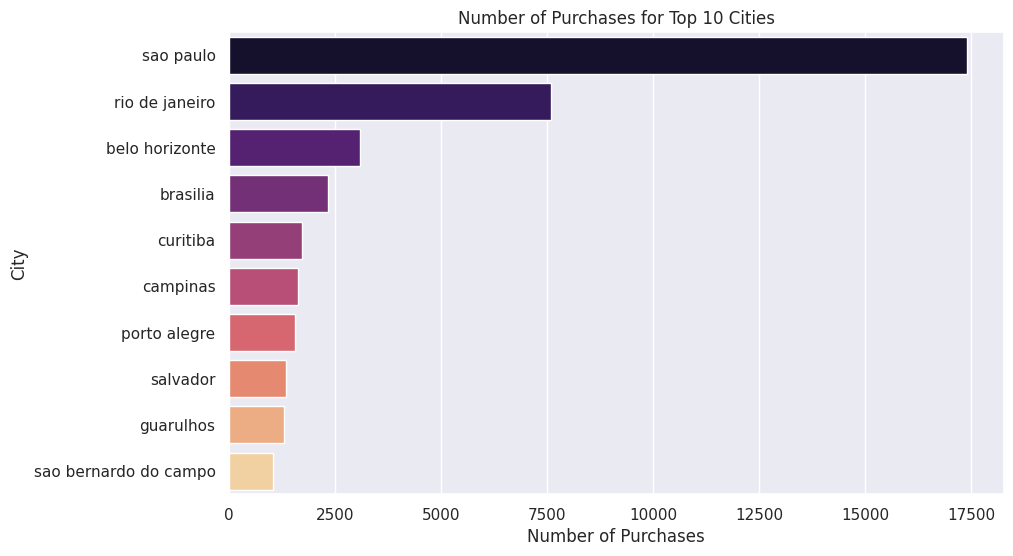

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top cities
sns.set(rc={'figure.figsize': (10,6)})
sns.barplot(
    y='customer_city',
    x='order_count',   # note: renamed from 'order_id' during aggregation
    data=df_city_big,
    palette='magma'
)

plt.title('Number of Purchases for Top 10 Cities')
plt.xlabel('Number of Purchases')
plt.ylabel('City')
plt.show()


In [0]:
df_city_sorted_top5 = df_city.orderBy(F.desc("order_count")).limit(5).toPandas()
df_city_sorted_top5


,customer_city,order_count
0,sao paulo,17400
1,rio de janeiro,7592
2,belo horizonte,3087
3,brasilia,2341
4,curitiba,1727


/home/spark-c62dcf22-5347-44a3-8b04-1d/.ipykernel/2566/command-5214476281148457-2438909640:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


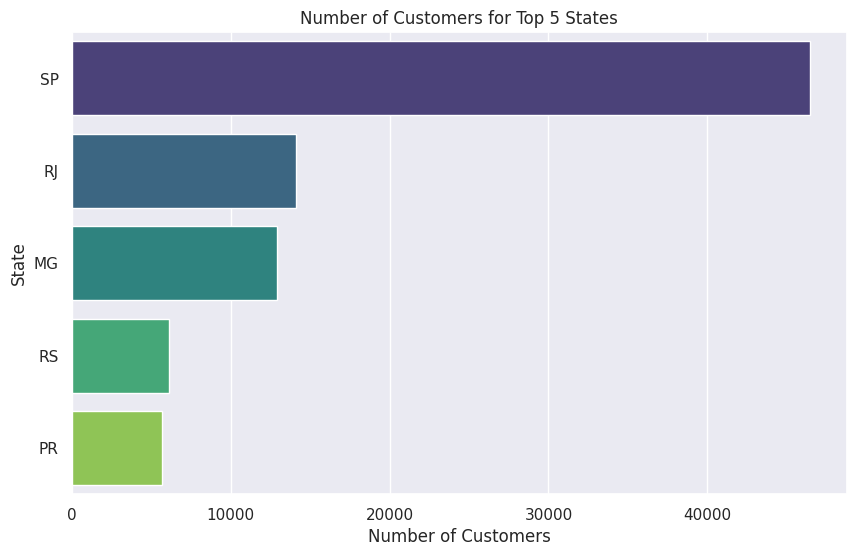

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1. Count customers per state
state_counts = (
    df.groupBy("customer_state")
      .count()
      .orderBy(F.desc("count"))
      .limit(5)   # top 5 states
      .toPandas()
)

# 2. Plot
sns.set(rc={'figure.figsize': (10, 6)})
sns.barplot(
    y='customer_state',
    x='count',
    data=state_counts,
    palette='viridis'
)

plt.title('Number of Customers for Top 5 States')
plt.xlabel('Number of Customers')
plt.ylabel('State')
plt.show()


/home/spark-c62dcf22-5347-44a3-8b04-1d/.ipykernel/2566/command-5214476281148458-1341660456:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


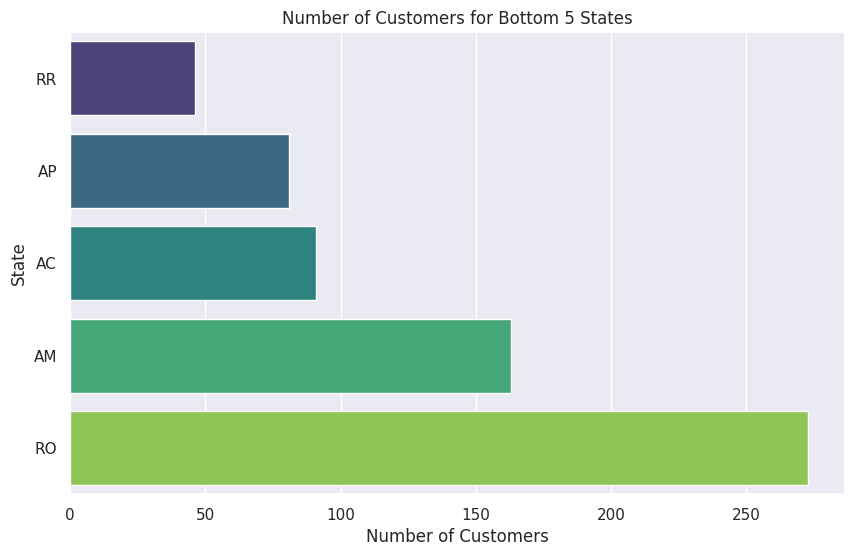

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1. Count customers per state and get bottom 5
state_counts_bottom = (
    df.groupBy("customer_state")
      .count()
      .orderBy("count")  # ascending → smallest counts first
      .limit(5)          # bottom 5 states
      .toPandas()
)

# 2. Plot
sns.set(rc={'figure.figsize': (10, 6)})
sns.barplot(
    y='customer_state',
    x='count',
    data=state_counts_bottom,
    palette='viridis'
)

plt.title('Number of Customers for Bottom 5 States')
plt.xlabel('Number of Customers')
plt.ylabel('State')
plt.show()


In [0]:
from pyspark.sql import functions as F

# Count customers per state
state_counts = df.groupBy("customer_state").count()

# Sort ascending to get the bottom 5
bottom_5_states = (
    state_counts.orderBy("count")   # ascending → fewest customers first
                .limit(5)           # take bottom 5
)
bottom_5_pd = bottom_5_states.toPandas().set_index("customer_state")["count"]
print(bottom_5_pd)


customer_state
RR     46
AP     81
AC     91
AM    163
RO    273
Name: count, dtype: int64


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# 1. Aggregate by purchase_year and purchase_yearmonth
df_bulan = (
    df.groupBy("purchase_year", "purchase_yearmonth")
      .agg(
          F.count("order_id").alias("order_count"),          # jumlah pembelian
          F.sum("price").alias("total_price"),              # total harga pembelian
          F.sum("freight_value").alias("total_freight")    # total harga pengiriman
      )
)

# 2. Calculate averages per order
df_bulan = df_bulan.withColumn("price_per_order", F.col("total_price") / F.col("order_count")) \
                   .withColumn("freight_per_order", F.col("total_freight") / F.col("order_count"))

# 3. Convert purchase_yearmonth to string type
df_bulan = df_bulan.withColumn("purchase_yearmonth", F.col("purchase_yearmonth").cast(StringType()))

# 4. Show top rows
df_bulan.show(5)


+-------------+------------------+-----------+------------------+------------------+------------------+------------------+
|purchase_year|purchase_yearmonth|order_count|       total_price|     total_freight|   price_per_order| freight_per_order|
+-------------+------------------+-----------+------------------+------------------+------------------+------------------+
|         2017|            201711|       8475| 987765.3700000346|165598.83000000328| 116.5504861356973|  19.5396849557526|
|         2018|            201805|       7810| 977544.6900000281|151229.83000000016| 125.1657733674812|19.363614596670956|
|         2018|            201802|       7518|  826437.130000027|139731.28000000058|  109.927790635811|18.586230380420403|
|         2018|            201806|       7010| 856077.8600000197|155900.43000000075|122.12237660485302| 22.23971897289597|
|         2017|            201706|       3489|421923.37000000395| 68126.99999999935| 120.9295987388948|19.526225279449513|
+-------------+-

/home/spark-c62dcf22-5347-44a3-8b04-1d/.ipykernel/2566/command-5214476281148462-785262296:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


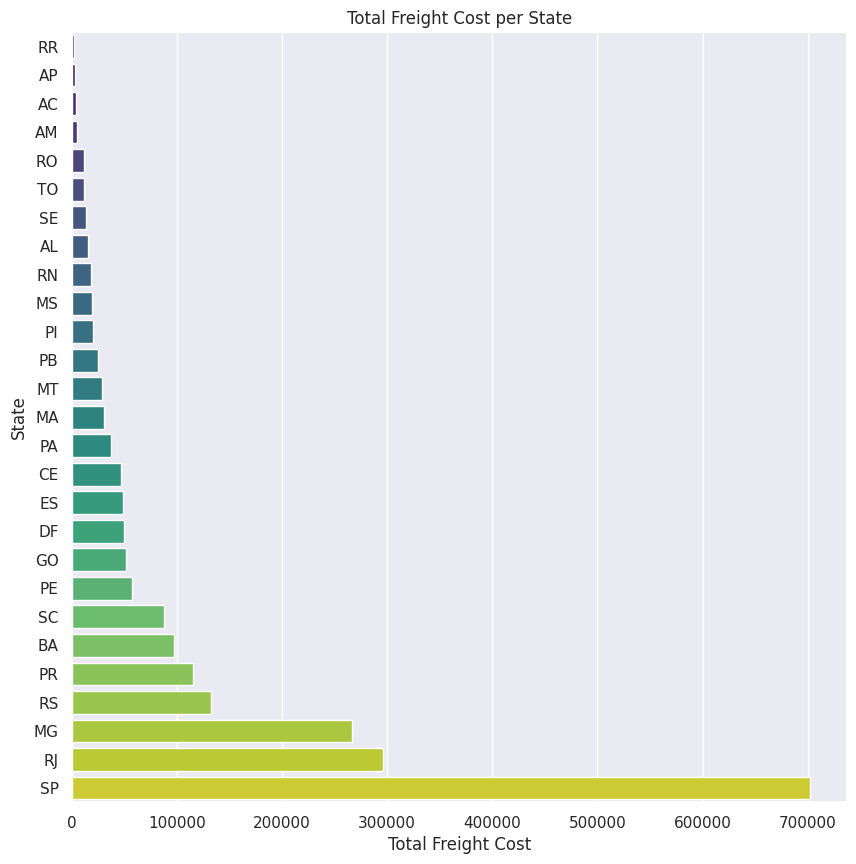

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1. Aggregate total freight per state
freight_per_state = (
    df.groupBy("customer_state")
      .agg(F.sum("freight_value").alias("total_freight"))
      .orderBy("total_freight")  # ascending, like sort_values
      .toPandas()                # convert to pandas for plotting
)

# 2. Plot horizontal bar chart
sns.set(rc={'figure.figsize': (10, 10)})
sns.barplot(
    y='customer_state',
    x='total_freight',
    data=freight_per_state,
    palette='viridis'
)

plt.title('Total Freight Cost per State')
plt.xlabel('Total Freight Cost')
plt.ylabel('State')
plt.show()


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, TimestampType

# 1. Join orders → items → payments
df1 = (
    or_dat.alias("o")
    .join(or_item.alias("oi"), on="order_id", how="inner")
    .join(or_pay.alias("op"), on="order_id", how="inner")
    .withColumn("price", F.col("price").cast(DoubleType()))
    .withColumn("order_purchase_timestamp", F.col("order_purchase_timestamp").cast(TimestampType()))
)

# 2. Filter out rows with null timestamps or price
df1 = df1.filter(F.col("order_purchase_timestamp").isNotNull() & F.col("price").isNotNull())

# 3. Check sample
df1.select("customer_id", "order_id", "price", "order_purchase_timestamp").show(5)


+--------------------+--------------------+-----+------------------------+
|         customer_id|            order_id|price|order_purchase_timestamp|
+--------------------+--------------------+-----+------------------------+
|9ef432eb625129730...|e481f51cbdc54678b...|29.99|     2017-10-02 10:56:33|
|b0830fb4747a6c6d2...|53cdb2fc8bc7dce0b...|118.7|     2018-07-24 20:41:37|
|41ce2a54c0b03bf34...|47770eb9100c2d0c4...|159.9|     2018-08-08 08:38:49|
|f88197465ea7920ad...|949d5b44dbf5de918...| 45.0|     2017-11-18 19:28:06|
|8ab97904e6daea886...|ad21c59c0840e6cb8...| 19.9|     2018-02-13 21:18:39|
+--------------------+--------------------+-----+------------------------+
only showing top 5 rows


In [0]:
df1.show(5)

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+------------------+------------+--------------------+-------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|payment_sequential|payment_type|payment_installments|payment_value|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+------

In [0]:
rfm_test = (
    df1.groupBy("customer_id")
       .agg(
           F.max("order_purchase_timestamp").alias("last_purchase"),
           F.count("order_id").alias("frequency"),
           F.sum("price").alias("monetary")
       )
)
rfm_test.show(5, truncate=False)


+--------------------------------+-------------------+---------+--------+
|customer_id                     |last_purchase      |frequency|monetary|
+--------------------------------+-------------------+---------+--------+
|43d9a8df81f815755d9a258f2ee3135f|2016-10-09 10:34:58|1        |119.5   |
|809c3dc9eabbbe4e6b03198d239b6e2d|2018-01-30 09:37:46|1        |179.0   |
|987d489e68b88750c3f60a22c29faa18|2018-03-14 09:52:04|2        |577.8   |
|c41577db6be598c85be04a2d94c3a8eb|2018-02-28 20:23:05|1        |116.6   |
|b331b74b18dc79bcdf6532d51e1637c1|2018-01-08 21:28:27|2        |359.98  |
+--------------------------------+-------------------+---------+--------+
only showing top 5 rows


In [0]:
from pyspark.sql import functions as F
from datetime import datetime

now = datetime.now()

# 1. Compute recency
rfm = rfm_test.withColumn(
    "recency", F.datediff(F.lit(now), F.col("last_purchase"))
)

# 2. Safe quantiles
def safe_quantiles(df, col):
    q = df.approxQuantile(col, [0.25, 0.5, 0.75], 0)
    if not q:
        q = [0, 0, 0]
    while len(q) < 3:
        q.append(q[-1])
    return q

rec_q = safe_quantiles(rfm, "recency")
freq_q = safe_quantiles(rfm, "frequency")
mon_q = safe_quantiles(rfm, "monetary")

print("Recency quantiles:", rec_q)
print("Frequency quantiles:", freq_q)
print("Monetary quantiles:", mon_q)

# 3. Assign RFM scores
rfm = (
    rfm
    .withColumn(
        "recency_score",
        F.when(F.col("recency") <= rec_q[0], 4)
         .when(F.col("recency") <= rec_q[1], 3)
         .when(F.col("recency") <= rec_q[2], 2)
         .otherwise(1)
    )
    .withColumn(
        "frequency_score",
        F.when(F.col("frequency") <= freq_q[0], 1)
         .when(F.col("frequency") <= freq_q[1], 2)
         .when(F.col("frequency") <= freq_q[2], 3)
         .otherwise(4)
    )
    .withColumn(
        "monetary_score",
        F.when(F.col("monetary") <= mon_q[0], 1)
         .when(F.col("monetary") <= mon_q[1], 2)
         .when(F.col("monetary") <= mon_q[2], 3)
         .otherwise(4)
    )
    .withColumn("RFM_Score", F.col("recency_score") + F.col("frequency_score") + F.col("monetary_score"))
)

rfm.show(10)


Recency quantiles: [2827.0, 2932.0, 3061.0]
Frequency quantiles: [1.0, 1.0, 1.0]
Monetary quantiles: [47.49, 89.1, 154.0]
+--------------------+-------------------+---------+--------+-------+-------------+---------------+--------------+---------+
|         customer_id|      last_purchase|frequency|monetary|recency|recency_score|frequency_score|monetary_score|RFM_Score|
+--------------------+-------------------+---------+--------+-------+-------------+---------------+--------------+---------+
|43d9a8df81f815755...|2016-10-09 10:34:58|        1|   119.5|   3399|            1|              1|             3|        5|
|809c3dc9eabbbe4e6...|2018-01-30 09:37:46|        1|   179.0|   2921|            3|              1|             4|        8|
|987d489e68b88750c...|2018-03-14 09:52:04|        2|   577.8|   2878|            3|              4|             4|       11|
|c41577db6be598c85...|2018-02-28 20:23:05|        1|   116.6|   2892|            3|              1|             3|        7|
|b3

In [0]:
from pyspark.sql import functions as F

# R score
rfm = rfm.withColumn(
    "R_score",
    F.when(F.col("recency") <= 14, 5)
     .when(F.col("recency") <= 30, 4)
     .when(F.col("recency") <= 60, 3)
     .when(F.col("recency") <= 180, 2)
     .otherwise(1)
)

# F score
rfm = rfm.withColumn(
    "F_score",
    F.when(F.col("frequency") <= 1, 1)
     .when(F.col("frequency") <= 2, 2)
     .when(F.col("frequency") <= 4, 3)
     .when(F.col("frequency") <= 6, 4)
     .otherwise(5)
)

# M score
rfm = rfm.withColumn(
    "M_score",
    F.when(F.col("monetary") <= 250, 1)
     .when(F.col("monetary") <= 500, 2)
     .when(F.col("monetary") <= 1000, 3)
     .when(F.col("monetary") <= 2000, 4)
     .otherwise(5)
)

# Combine into final RFM_score (e.g., 5*100 + 4*10 + 3 = 543)
rfm = rfm.withColumn(
    "RFM_score",
    F.col("R_score") * 100 + F.col("F_score") * 10 + F.col("M_score")
)

# Show top 5
rfm.show(5)


+--------------------+-------------------+---------+--------+-------+-------------+---------------+--------------+---------+-------+-------+-------+
|         customer_id|      last_purchase|frequency|monetary|recency|recency_score|frequency_score|monetary_score|RFM_score|R_score|F_score|M_score|
+--------------------+-------------------+---------+--------+-------+-------------+---------------+--------------+---------+-------+-------+-------+
|43d9a8df81f815755...|2016-10-09 10:34:58|        1|   119.5|   3399|            1|              1|             3|      111|      1|      1|      1|
|809c3dc9eabbbe4e6...|2018-01-30 09:37:46|        1|   179.0|   2921|            3|              1|             4|      111|      1|      1|      1|
|987d489e68b88750c...|2018-03-14 09:52:04|        2|   577.8|   2878|            3|              4|             4|      123|      1|      2|      3|
|c41577db6be598c85...|2018-02-28 20:23:05|        1|   116.6|   2892|            3|              1|       

In [0]:
from pyspark.sql import functions as F

# 1. Count the number of customers per F-R pair
rfm_count_df = (
    rfm.groupBy("F_score", "R_score")
       .agg(F.count("RFM_score").alias("count"))
)

# 2. Optional: pivot so F_score is rows, R_score is columns
rfm_count_pivot = rfm_count_df.groupBy("F_score") \
    .pivot("R_score") \
    .sum("count") \
    .fillna(0) \
    .orderBy("F_score")  # optional: sort rows

# 3. Show
rfm_count_pivot.show()


+-------+-----+
|F_score|    1|
+-------+-----+
|      1|86202|
|      2| 9428|
|      3| 2345|
|      4|  520|
|      5|  170|
+-------+-----+



In [0]:
from pyspark.sql import functions as F

# Median requires approxQuantile per group (no built-in pivot median), so do groupBy and aggregate
rfm_median_df = (
    rfm.groupBy("F_score", "R_score")
       .agg(F.expr("percentile_approx(monetary, 0.5)").alias("median_monetary"))
)

# Pivot to make R_score columns
rfm_median_pivot = rfm_median_df.groupBy("F_score") \
    .pivot("R_score") \
    .sum("median_monetary") \
    .fillna(0) \
    .orderBy("F_score")

rfm_median_pivot.show()


+-------+-----------------+
|F_score|                1|
+-------+-----------------+
|      1|            79.99|
|      2|           127.05|
|      3|            179.7|
|      4|            285.0|
|      5|773.4999999999999|
+-------+-----------------+



In [0]:
rfm_mean_pivot = (
    rfm.groupBy("F_score", "R_score")
       .agg(F.mean("monetary").alias("mean_monetary"))
       .groupBy("F_score")
       .pivot("R_score")
       .sum("mean_monetary")
       .fillna(0)
       .orderBy("F_score")
)

rfm_mean_pivot.show()


+-------+------------------+
|F_score|                 1|
+-------+------------------+
|      1| 130.1960999744699|
|      2|200.35978998727018|
|      3|273.36274626865725|
|      4|  439.578826923077|
|      5|1337.3082352941178|
+-------+------------------+



In [0]:
rfm_sum_pivot = (
    rfm.groupBy("F_score", "R_score")
       .agg(F.sum("monetary").alias("sum_monetary"))
       .groupBy("F_score")
       .pivot("R_score")
       .sum("sum_monetary")
       .fillna(0)
       .orderBy("F_score")
)

rfm_sum_pivot.show()


+-------+--------------------+
|F_score|                   1|
+-------+--------------------+
|      1|1.1223164209999252E7|
|      2|  1888992.0999999833|
|      3|   641035.6400000013|
|      4|  228580.99000000002|
|      5|  227342.40000000002|
+-------+--------------------+



In [0]:
from pyspark.sql import functions as F

# Aggregate metrics per RFM_score
rfm_agg = (
    rfm.groupBy("RFM_score")
       .agg(
           F.count("RFM_score").alias("count"),
           F.sum("monetary").alias("monetary_sum"),
           F.mean("monetary").alias("monetary_mean"),
           F.expr("percentile_approx(monetary, 0.5)").alias("monetary_median")
       )
       .orderBy("RFM_score")
)

rfm_agg.show()


+---------+-----+------------------+------------------+------------------+
|RFM_score|count|      monetary_sum|     monetary_mean|   monetary_median|
+---------+-----+------------------+------------------+------------------+
|      111|77833| 6678227.199999278| 85.80200172162552|             69.99|
|      112| 5477|1866607.2400000072| 340.8083330290318|             329.0|
|      113| 2135|1473958.4700000007| 690.3786744730683|             655.0|
|      114|  645| 893160.0399999995|1384.7442480620145|           1299.99|
|      115|  112|         311211.26|2778.6719642857142|            2470.5|
|      121| 7480| 847425.5599999945|113.29218716577466|            103.84|
|      122| 1451| 496353.6600000003|342.07695382494853|             329.8|
|      123|  334|225917.32000000007| 676.3991616766469|             650.0|
|      124|  115|         164625.74|1431.5281739130435|            1398.0|
|      125|   48|         154669.82|3222.2879166666667|           2799.98|
|      131| 1547|204290.9

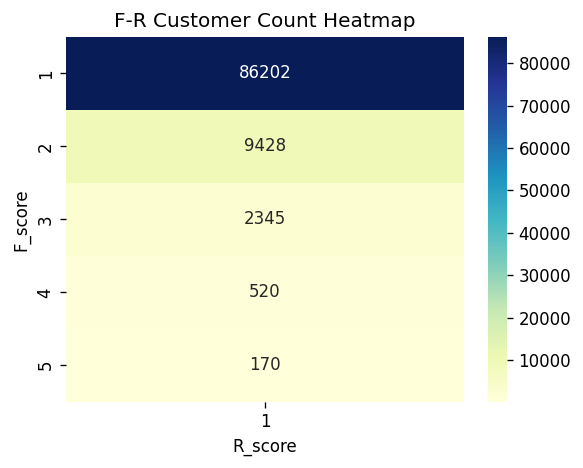

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose rfm_count_pivot is your Spark pivot table for F-R counts
# 1. Convert to Pandas
rfm_count_pd = rfm_count_pivot.toPandas().set_index("F_score")  # F_score as row index

# 2. Plot heatmap
plt.figure(figsize=(5, 4), dpi=120)
sns.heatmap(rfm_count_pd, annot=True, fmt="d", cmap="YlGnBu")  # fmt="d" for integer counts
plt.title("F-R Customer Count Heatmap")
plt.ylabel("F_score")
plt.xlabel("R_score")
plt.tight_layout()
plt.show()


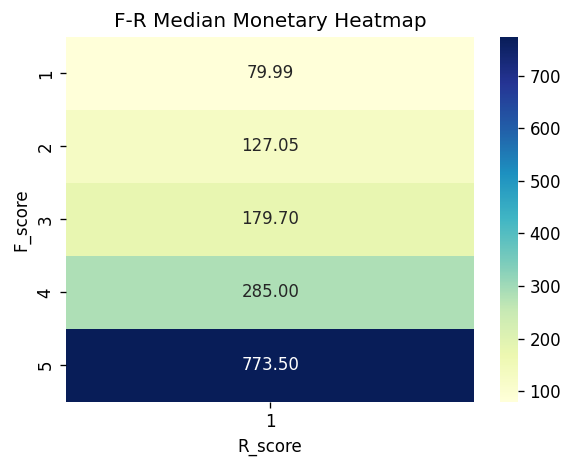

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Step 1: Compute median monetary per F-R pair in Spark
rfm_median_df = (
    rfm.groupBy("F_score", "R_score")
       .agg(F.expr("percentile_approx(monetary, 0.5)").alias("median_monetary"))
       .groupBy("F_score")
       .pivot("R_score")
       .sum("median_monetary")
       .fillna(0)
       .orderBy("F_score")
)

# Step 2: Convert pivot table to Pandas
rfm_median_pd = rfm_median_df.toPandas().set_index("F_score")

# Step 3: Plot heatmap
plt.figure(figsize=(5, 4), dpi=120)
sns.heatmap(rfm_median_pd, annot=True, fmt=".2f", cmap="YlGnBu")  # fmt=".2f" for monetary values
plt.title("F-R Median Monetary Heatmap")
plt.ylabel("F_score")
plt.xlabel("R_score")
plt.tight_layout()
plt.show()


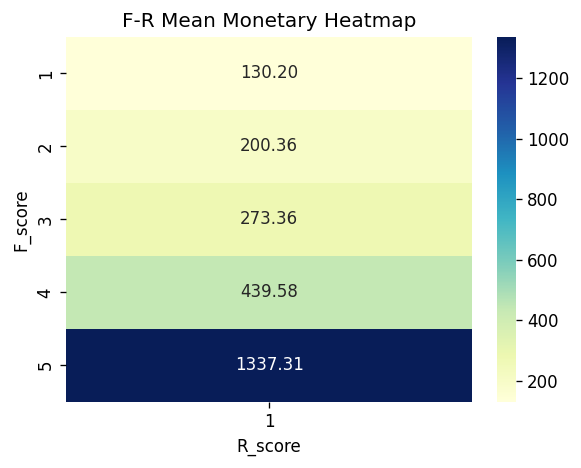

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Step 1: Compute mean monetary per F-R pair in Spark
rfm_mean_df = (
    rfm.groupBy("F_score", "R_score")
       .agg(F.mean("monetary").alias("mean_monetary"))
       .groupBy("F_score")
       .pivot("R_score")
       .sum("mean_monetary")
       .fillna(0)
       .orderBy("F_score")
)

# Step 2: Convert pivot table to Pandas
rfm_mean_pd = rfm_mean_df.toPandas().set_index("F_score")

# Step 3: Plot heatmap
plt.figure(figsize=(5, 4), dpi=120)
sns.heatmap(rfm_mean_pd, annot=True, fmt=".2f", cmap="YlGnBu")  # fmt=".2f" for monetary values
plt.title("F-R Mean Monetary Heatmap")
plt.ylabel("F_score")
plt.xlabel("R_score")
plt.tight_layout()
plt.show()


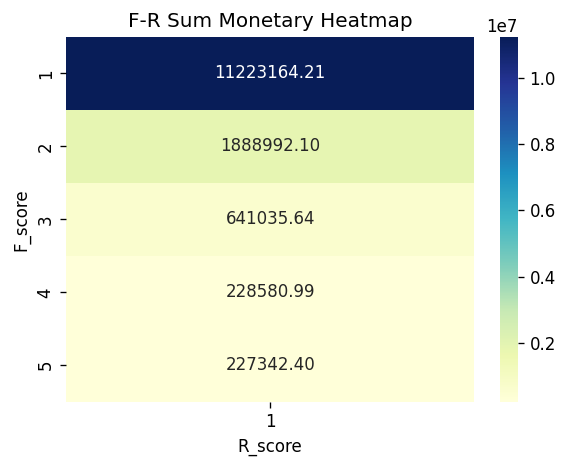

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Step 1: Compute sum monetary per F-R pair in Spark
rfm_sum_df = (
    rfm.groupBy("F_score", "R_score")
       .agg(F.sum("monetary").alias("sum_monetary"))
       .groupBy("F_score")
       .pivot("R_score")
       .sum("sum_monetary")
       .fillna(0)
       .orderBy("F_score")
)

# Step 2: Convert pivot table to Pandas
rfm_sum_pd = rfm_sum_df.toPandas().set_index("F_score")

# Step 3: Plot heatmap
plt.figure(figsize=(5, 4), dpi=120)
sns.heatmap(rfm_sum_pd, annot=True, fmt=".2f", cmap="YlGnBu")  # fmt=".2f" for monetary values
plt.title("F-R Sum Monetary Heatmap")
plt.ylabel("F_score")
plt.xlabel("R_score")
plt.tight_layout()
plt.show()


In [0]:
from pyspark.sql import functions as F

# 1. Create the Segment code as R_score*10 + F_score
rfm = rfm.withColumn("Segment_code", (F.col("R_score")*10 + F.col("F_score")).cast("string"))

# 2. Define the segmentation rules as a list of (regex, label)
segmentation = [
    (r'[2-5][4-5]', 'VIPs'),
    (r'[2-5]3', 'Potential loyalists'),
    (r'[1-5]2', 'Need to focus'),
    (r'1[3-5]', 'Good old friends'),
    (r'[4-5]1', 'New customers'),
    (r'[1-3]1', 'Hibernating')
]

# 3. Apply regex replacement using a when/otherwise chain
seg_col = F.lit(None)
for pattern, label in segmentation:
    seg_col = F.when(F.col("Segment_code").rlike(pattern), label).otherwise(seg_col)

rfm = rfm.withColumn("Segment", seg_col)

# 4. Show sample
rfm.select("customer_id", "R_score", "F_score", "Segment_code", "Segment").show(10)


+--------------------+-------+-------+------------+-------------+
|         customer_id|R_score|F_score|Segment_code|      Segment|
+--------------------+-------+-------+------------+-------------+
|43d9a8df81f815755...|      1|      1|          11|  Hibernating|
|809c3dc9eabbbe4e6...|      1|      1|          11|  Hibernating|
|987d489e68b88750c...|      1|      2|          12|Need to focus|
|c41577db6be598c85...|      1|      1|          11|  Hibernating|
|b331b74b18dc79bcd...|      1|      2|          12|Need to focus|
|4e46b98e954d79ebb...|      1|      1|          11|  Hibernating|
|841991865fe44b9b4...|      1|      2|          12|Need to focus|
|04fc2ecbb192c7116...|      1|      1|          11|  Hibernating|
|791d0d1144e6fb660...|      1|      1|          11|  Hibernating|
|05860a17b17441a53...|      1|      1|          11|  Hibernating|
+--------------------+-------+-------+------------+-------------+
only showing top 10 rows


In [0]:
from pyspark.sql import functions as F

# Aggregate metrics per Segment
rfm_segment = (
    rfm.groupBy("Segment")
       .agg(
           F.round(F.mean("recency"), 0).cast("int").alias("recency_mean"),
           F.expr("percentile_approx(recency, 0.5)").cast("int").alias("recency_median"),
           F.round(F.mean("frequency"), 0).cast("int").alias("frequency_mean"),
           F.expr("percentile_approx(frequency, 0.5)").cast("int").alias("frequency_median"),
           F.round(F.mean("monetary"), 0).cast("int").alias("monetary_mean"),
           F.expr("percentile_approx(monetary, 0.5)").cast("int").alias("monetary_median"),
           F.round(F.sum("monetary"), 0).cast("int").alias("monetary_sum"),
           F.count("monetary").alias("count")
       )
       .orderBy("Segment")
)

rfm_segment.show()


+----------------+------------+--------------+--------------+----------------+-------------+---------------+------------+-----+
|         Segment|recency_mean|recency_median|frequency_mean|frequency_median|monetary_mean|monetary_median|monetary_sum|count|
+----------------+------------+--------------+--------------+----------------+-------------+---------------+------------+-----+
|Good old friends|        2955|          2939|             4|               3|          361|            200|     1096959| 3035|
|     Hibernating|        2950|          2931|             1|               1|          130|             79|    11223164|86202|
|   Need to focus|        2956|          2937|             2|               2|          200|            127|     1888992| 9428|
+----------------+------------+--------------+--------------+----------------+-------------+---------------+------------+-----+



In [0]:
segment_counts = (
    rfm_segment
    .select("Segment", F.col("count").alias("customer_count"))
    .orderBy("customer_count")
)

segment_counts.orderBy(F.col("customer_count").desc()).show()


+----------------+--------------+
|         Segment|customer_count|
+----------------+--------------+
|     Hibernating|         86202|
|   Need to focus|          9428|
|Good old friends|          3035|
+----------------+--------------+



In [0]:
segment_monetary_sum = (
    rfm_segment
    .select("Segment", F.col("monetary_sum"))
    .orderBy("monetary_sum")
)

segment_monetary_sum.show()


+----------------+------------+
|         Segment|monetary_sum|
+----------------+------------+
|Good old friends|     1096959|
|   Need to focus|     1888992|
|     Hibernating|    11223164|
+----------------+------------+



In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def hbar_pyspark(rfm_segment_df):
    w = Window.orderBy("customer_count")

    total = rfm_segment_df.agg(F.sum("count")).first()[0]

    return (
        rfm_segment_df
        .select(
            F.col("Segment"),
            F.col("count").alias("customer_count")
        )
        .withColumn("percentage", F.round(F.col("customer_count") * 100 / F.lit(total), 0))
        .withColumn("is_vip", F.col("Segment") == "VIPs")
        .orderBy("customer_count")
    )


In [0]:
segment_counts_spark = hbar_pyspark(rfm_segment)
segment_counts_spark.show()


+----------------+--------------+----------+------+
|         Segment|customer_count|percentage|is_vip|
+----------------+--------------+----------+------+
|Good old friends|          3035|       3.0| false|
|   Need to focus|          9428|      10.0| false|
|     Hibernating|         86202|      87.0| false|
+----------------+--------------+----------+------+



In [0]:
def hbar(data):
    num_of_segment = len(data)

    ax.set_frame_on(False)
    ax.set_yticks(range(num_of_segment))
    ax.set_yticklabels(data.index)

    bars = ax.barh(range(num_of_segment), data, color='silver')

    for i, bar in enumerate(bars):
        value = bar.get_width()
        if data.index[i] == 'VIPs':
            bar.set_color('firebrick')

        ax.text(
            value,
            bar.get_y() + bar.get_height() / 2,
            f'{int(value):,} ({int(value * 100 / data.sum())}%)',
            va='center',
            ha='left'
        )


In [0]:
def spark_to_series(df, key_col, value_col):
    return df.toPandas().set_index(key_col)[value_col]


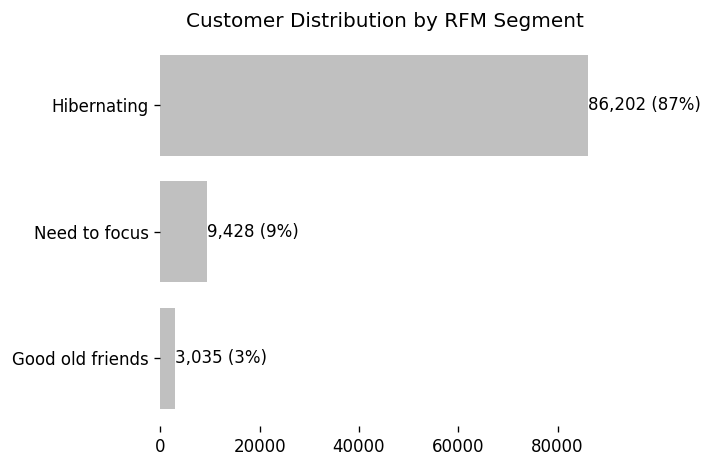

In [0]:
segment_counts_pd = spark_to_series(
    rfm_segment.select("Segment", "count").orderBy("count"),
    "Segment",
    "count"
)

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
hbar(segment_counts_pd)
plt.title("Customer Distribution by RFM Segment")
plt.tight_layout()
plt.show()


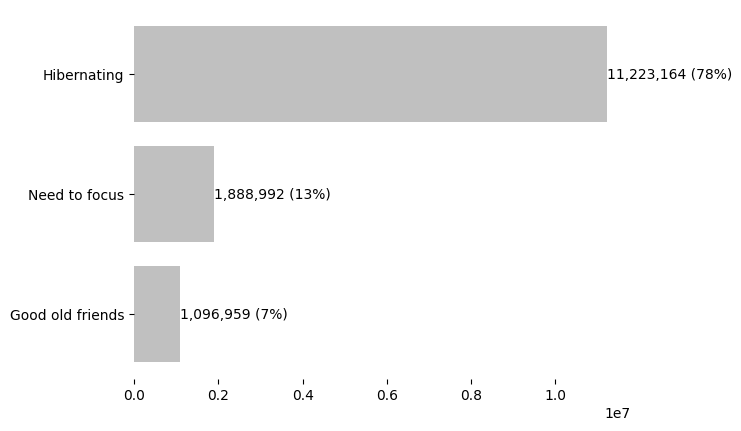

In [0]:
segment_monetary_sum_pd = (
    segment_monetary_sum
    .toPandas()
    .set_index("Segment")["monetary_sum"]
)
fig, ax = plt.subplots()
hbar(segment_monetary_sum_pd)
plt.show()


Customer Segmentation with k-means

In [0]:
from pyspark.sql import functions as F

# Group by customer_unique_id
rfm = df1.groupBy("customer_id").agg(
    (F.max("order_purchase_timestamp").cast("long") - F.max("order_purchase_timestamp")).alias("recency_days"),
    F.count("order_id").alias("frequency"),
    F.sum("price").alias("monetary")
)

# If you want recency in days from now
from pyspark.sql.functions import current_timestamp, datediff

rfm = df1.groupBy("customer_id").agg(
    datediff(F.current_timestamp(), F.max("order_purchase_timestamp")).alias("recency"),
    F.count("order_id").alias("frequency"),
    F.sum("price").alias("monetary")
)

rfm.show(5)


+--------------------+-------+---------+--------+
|         customer_id|recency|frequency|monetary|
+--------------------+-------+---------+--------+
|f7398fc942c8fa80e...|   2846|        1|    45.0|
|d0b0b2dd8bdaf36eb...|   2792|        1|    64.0|
|66e8039d5fddd7506...|   2978|        1|    49.9|
|c2928a50aecf1bc47...|   2936|        1|   139.9|
|ba76714c489437232...|   3181|        2|   139.8|
+--------------------+-------+---------+--------+
only showing top 5 rows


In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# 1. Combine RFM features
assembler = VectorAssembler(inputCols=['recency', 'frequency', 'monetary'], outputCol='features_vec')
rfm_vec = assembler.transform(rfm)

# 2. Scale features
scaler = StandardScaler(inputCol='features_vec', outputCol='scaled_features', withMean=True, withStd=True)
scaler_model = scaler.fit(rfm_vec)
rfm_scaled = scaler_model.transform(rfm_vec)

# 3. Silhouette scores for k=2..8
evaluator = ClusteringEvaluator(featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')
scores = []
k_list = list(range(2, 9))
for k in k_list:
    model = KMeans(featuresCol='scaled_features', k=k, seed=42).fit(rfm_scaled)
    pred = model.transform(rfm_scaled)
    score = evaluator.evaluate(pred)
    print(f'Silhouette Score for {k} clusters: {score:.3f}')
    scores.append(score)

# 4. Fit final KMeans (k=5)
kmeans = KMeans(featuresCol='scaled_features', k=5, seed=10)
model = kmeans.fit(rfm_scaled)
rfm_clusters = model.transform(rfm_scaled)

# 5. Map cluster IDs to human-readable labels
def label(x):
    if x == 0:
        return 'New Customer'
    elif x == 1:
        return 'Hibernating'
    elif x == 2:
        return 'Need to focus'
    elif x == 3:
        return 'Potential loyalists'
    else:
        return 'VIP'

label_udf = udf(label, StringType())
rfm_clusters = rfm_clusters.withColumn("label_kmeans", label_udf(col("prediction")))

# 6. Count of customers per segment
rfm_clusters.groupBy("label_kmeans").count().orderBy("count", ascending=False).show()


Silhouette Score for 2 clusters: 0.424
Silhouette Score for 3 clusters: 0.570
Silhouette Score for 4 clusters: 0.566
Silhouette Score for 5 clusters: 0.468
Silhouette Score for 6 clusters: 0.583
Silhouette Score for 7 clusters: 0.597
Silhouette Score for 8 clusters: 0.642
+-------------------+-----+
|       label_kmeans|count|
+-------------------+-----+
|                VIP|36384|
|        Hibernating|36078|
|       New Customer|23062|
|      Need to focus| 1697|
|Potential loyalists| 1444|
+-------------------+-----+



In [0]:
# rfm_clusters has columns: customer_id, label_kmeans
segments_pdf = rfm_clusters.select("customer_id", "label_kmeans").toPandas()

# Convert to dict for Streamlit
customer_segments = dict(zip(segments_pdf["customer_id"], segments_pdf["label_kmeans"]))

# Save as pickle
import pickle
with open("/tmp/customer_segments.pkl", "wb") as f:
    pickle.dump(customer_segments, f)

print("Customer segments saved to /tmp/customer_segments.pkl")


Customer segments saved to /tmp/customer_segments.pkl


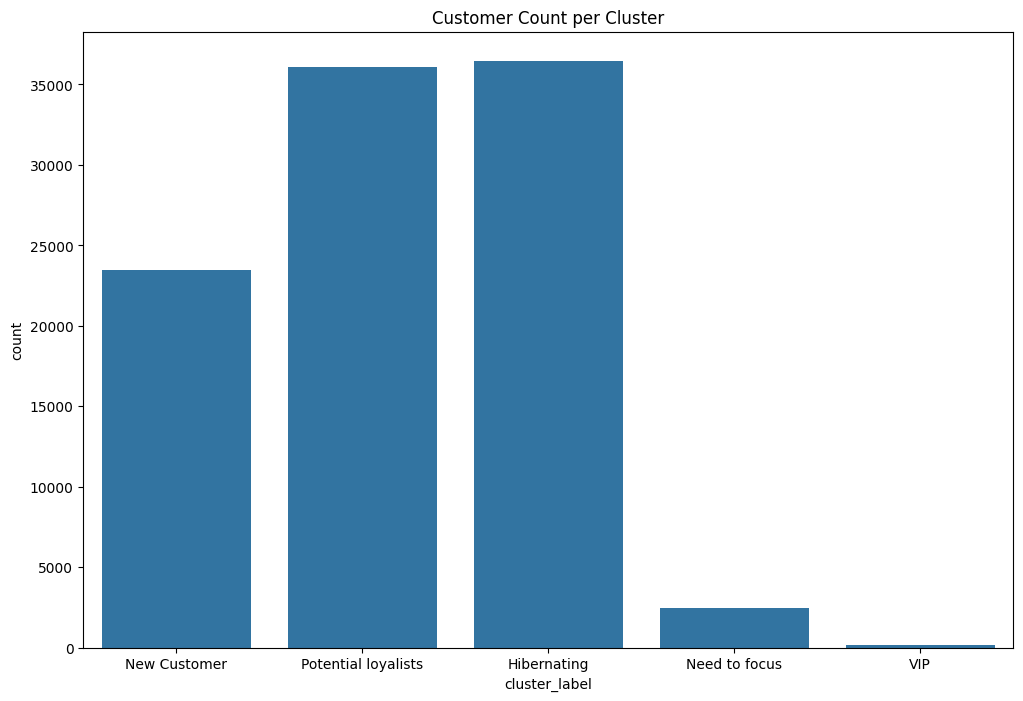

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark clusters to Pandas for plotting
rfm_pd = rfm_clusters.select(
    "recency", "frequency", "monetary", "prediction"  # <-- use 'prediction'
).toPandas()

# Optional: map cluster IDs to names
cluster_names = {0: 'New Customer', 1: 'Hibernating', 2: 'Need to focus', 3: 'Potential loyalists', 4: 'VIP'}
rfm_pd['cluster_label'] = rfm_pd['prediction'].map(cluster_names)

# Count plot
plt.figure(figsize=(12,8))
sns.countplot(x='cluster_label', data=rfm_pd)
plt.title("Customer Count per Cluster")
plt.show()


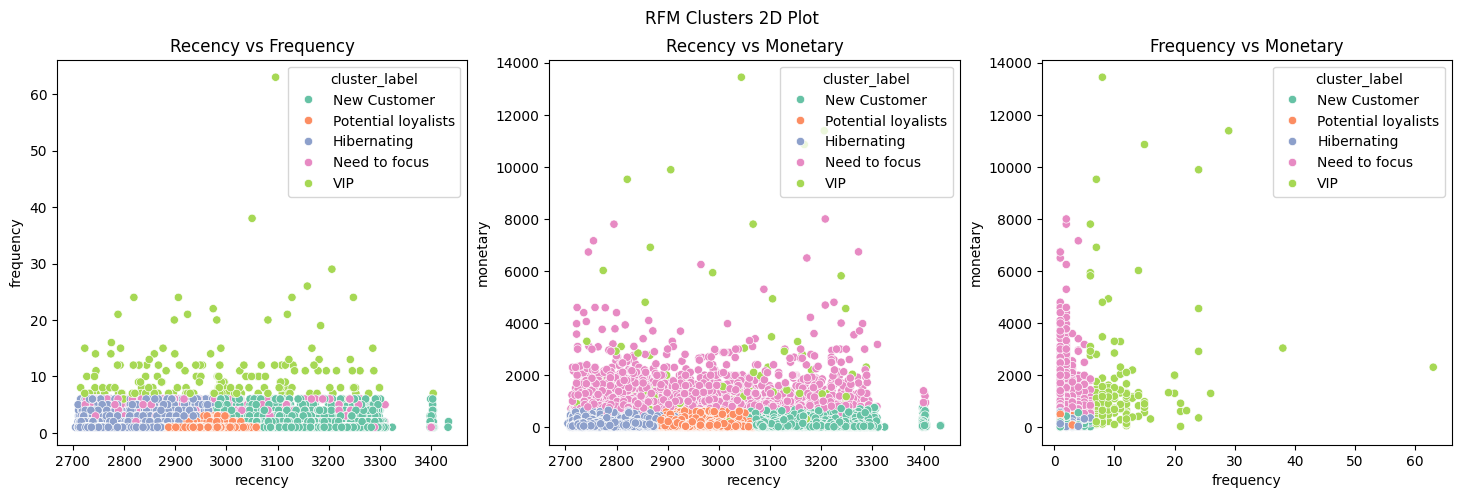

In [0]:

# 2D Scatter plots
plt.figure(figsize=(18,5))

plt.subplot(131)
sns.scatterplot(x='recency', y='frequency', hue='cluster_label', data=rfm_pd, palette='Set2')
plt.title('Recency vs Frequency')

plt.subplot(132)
sns.scatterplot(x='recency', y='monetary', hue='cluster_label', data=rfm_pd, palette='Set2')
plt.title('Recency vs Monetary')

plt.subplot(133)
sns.scatterplot(x='frequency', y='monetary', hue='cluster_label', data=rfm_pd, palette='Set2')
plt.title('Frequency vs Monetary')

plt.suptitle('RFM Clusters 2D Plot')
plt.show()


Recommendation Engine

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, lit, explode
import numpy as np

rec_data= spark.table("rec_data")



In [0]:
from pyspark.sql import functions as F

# 1️⃣ Delete old model object
try:
    if 'model' in locals(): model.unpersist(); del model
except NameError:
    pass  # model doesn't exist yet, no problem

# 2️⃣ (Optional) Clear Python-side cache
import gc
gc.collect()



# Drop rows with nulls in customer_id, product_id, or review_score
ratings_indexed_clean = rec_data.dropna(subset=["customer_id", "product_id", "review_score"])

# Now apply StringIndexer
customer_indexer = StringIndexer(inputCol="customer_id", outputCol="customer_int", handleInvalid="skip").fit(ratings_indexed_clean)
product_indexer = StringIndexer(inputCol="product_id", outputCol="product_int", handleInvalid="skip").fit(ratings_indexed_clean)

ratings_indexed = customer_indexer.transform(ratings_indexed_clean)
ratings_indexed = product_indexer.transform(ratings_indexed)

# Fit ALS model
als = ALS(
    userCol="customer_int",
    itemCol="product_int",
    ratingCol="review_score",
    rank=10,
    maxIter=15,
    regParam=0.1,
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"
)

model = als.fit(ratings_indexed)


In [0]:
predictions = model.transform(ratings_indexed)

+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+--------------------+-------------+--------------------+-------------------+-----+-------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+--------------------+------------------------+--------------+--------------+------------+-----------+----------+
|          product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|            order_id|order_item_id|           seller_id|shipping_limit_date|price|freight_value|         customer_id|order_status|order_purc

In [0]:
predictions.select(
    "customer_int",
    "product_int",
    "prediction"
).show(10)


+------------+-----------+----------+
|customer_int|product_int|prediction|
+------------+-----------+----------+
|       95445|      17082|   4.93827|
|       11525|      19055| 4.9368515|
|       88542|      25457|  4.939775|
|       27334|      29413| 0.9001255|
|       76641|      25952| 4.9392223|
|       31828|      19559|  4.940105|
|       53375|      11607| 1.9621986|
|       26935|      11607| 4.9054966|
|         526|       1960| 1.8812404|
|         526|       1960| 1.8812404|
+------------+-----------+----------+
only showing top 10 rows


In [0]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import numpy as np

# Precompute norm column once for all products
def vector_norm(v):
    return float(np.linalg.norm(v))

norm_udf = udf(vector_norm, DoubleType())

product_factors_norm = (
    model.itemFactors
    .withColumn("norm", norm_udf(col("features")))
)

# Build a fast lookup for string -> int mapping
product_to_int = {p: i for i, p in enumerate(product_indexer.labels)}

def system_recommendation(product_id, top_n=9):
    # Map string product_id to indexed integer
    if product_id not in product_to_int:
        return f"Product {product_id} not found"

    product_int = product_to_int[product_id]

    # Get the target product vector
    target_row = (
        product_factors_norm
        .filter(col("id") == product_int)
        .select("features", "norm")
        .first()
    )
    target_vec = np.array(target_row.features)
    target_norm = target_row.norm

    # Cosine similarity UDF
    def cosine_sim(v):
        v = np.array(v)
        return float(np.dot(v, target_vec) / (np.linalg.norm(v) * target_norm))

    cosine_udf = udf(cosine_sim, DoubleType())

    # Compute similarity in Spark and get top N
    sims = (
        product_factors_norm
        .withColumn("similarity", cosine_udf(col("features")))
        .filter(col("id") != product_int)          # exclude self
        .orderBy(col("similarity").desc())
        .limit(top_n)
        .select("id")
        .collect()
    )

    # Map back to original product IDs
    return [product_indexer.labels[row.id] for row in sims]


In [0]:
product_factors_norm = (
    model.itemFactors
    .withColumn("norm", udf(lambda v: float(np.linalg.norm(v)), DoubleType())(col("features")))
)
product_to_int = {p: i for i, p in enumerate(product_indexer.labels)}


In [0]:
top_similar = system_recommendation("ff2c1ec09b1bb340e84f0d6b21cc7dbb", top_n=3)
print(top_similar)


['d7324d4c913e7b424cb61675dafc8c10', '57a0cb306bbd11620b9bbb927748b043', '17de10d52ada234d16d3991c1b9546f8']


In [0]:
# model = your trained ALS model
product_factors = model.itemFactors  # DataFrame with id (product_int) and features (vector)

# Collect to Python dict (safe if dataset is small)
product_factors_local = {row.id: row.features for row in product_factors.collect()}

# Map int -> product_id
product_indexer_labels = product_indexer.labels


In [0]:
import pickle

# Example data
data_to_save = {
    "product_vectors": product_factors_local,
    "product_labels": product_indexer_labels
}

local_path = "/tmp/cosine_model.pkl"

with open(local_path, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"Pickle saved to {local_path}")


Pickle saved to /tmp/cosine_model.pkl
